# Single Run Analysis

In [1]:
from analysis import *
import os
import yaml
config_path = os.path.join("..", "config.yaml")
# Load the configuration file
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
    EMOTIONS, RANDOM_SEED = (
        config["EMOTIONS"],
        config["RANDOM_SEED"],
    )


# Single Run Analysis

Number of empty predictions: 22


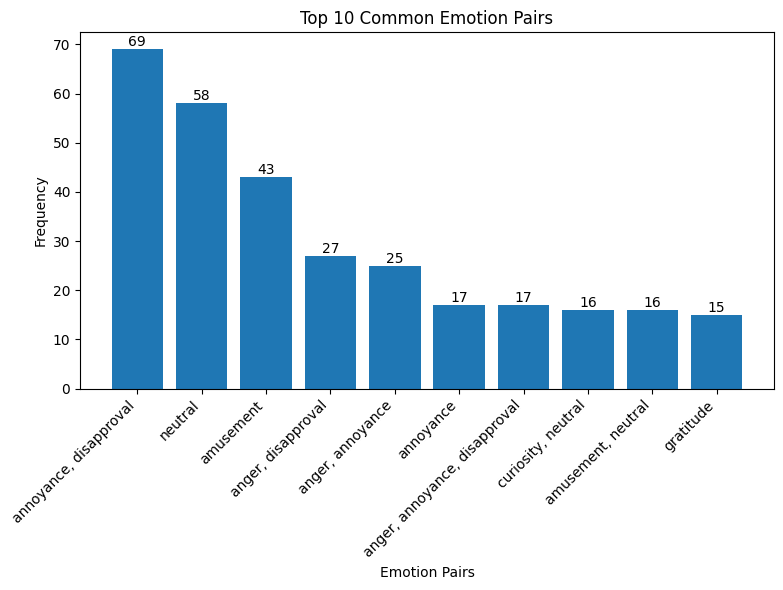

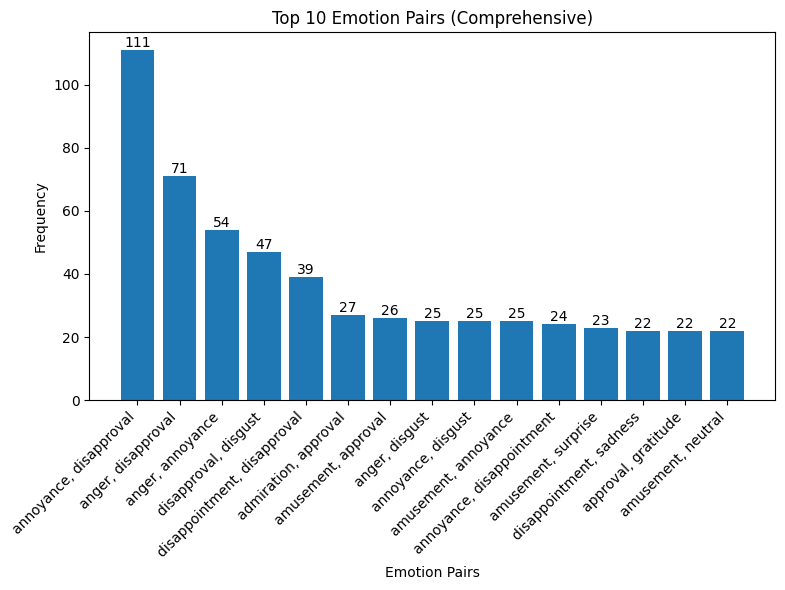

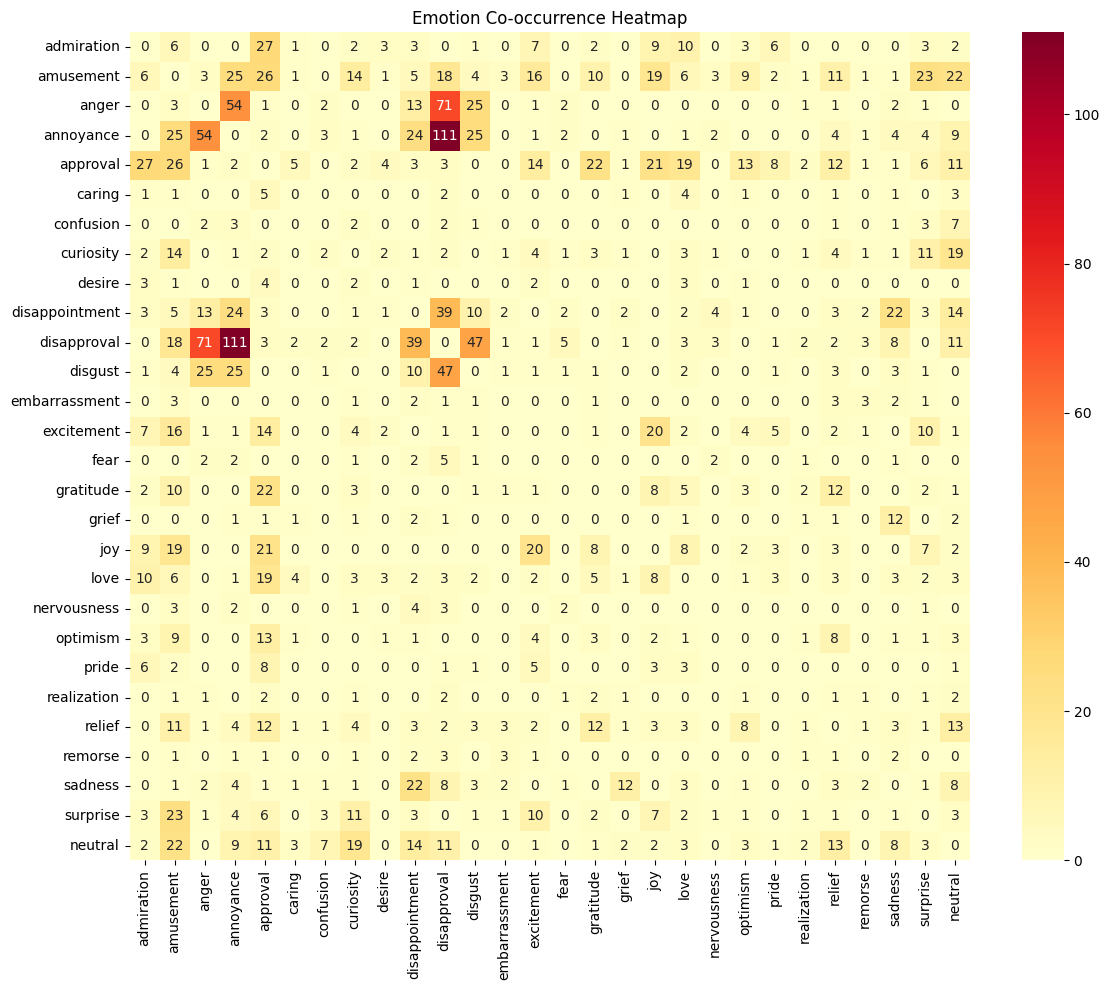


Top 10 Common Pairs
╒═══════════════════════════════╤═════════╕
│ Emotions                      │   Count │
╞═══════════════════════════════╪═════════╡
│ annoyance, disapproval        │      69 │
├───────────────────────────────┼─────────┤
│ neutral                       │      58 │
├───────────────────────────────┼─────────┤
│ amusement                     │      43 │
├───────────────────────────────┼─────────┤
│ anger, disapproval            │      27 │
├───────────────────────────────┼─────────┤
│ anger, annoyance              │      25 │
├───────────────────────────────┼─────────┤
│ annoyance                     │      17 │
├───────────────────────────────┼─────────┤
│ anger, annoyance, disapproval │      17 │
├───────────────────────────────┼─────────┤
│ curiosity, neutral            │      16 │
├───────────────────────────────┼─────────┤
│ amusement, neutral            │      16 │
├───────────────────────────────┼─────────┤
│ gratitude                     │      15 │
╘══════════

In [2]:
emotion_pair_analysis_pipeline(
    run_number=2,
    set_='train',
    config_path='../config.yaml',
    number=10,
    print_table=True)

# Runs Comparisons

Comparison between Run 2 and Run 3:
Average BCE Loss: 0.1481
Average F1 Score: 0.5050
Average Precision: 0.6660
Average Recall: 0.4394


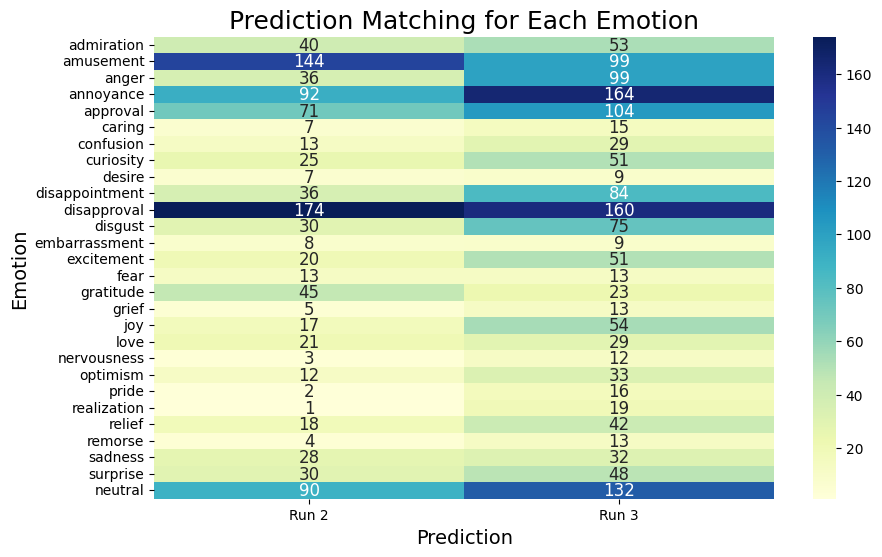

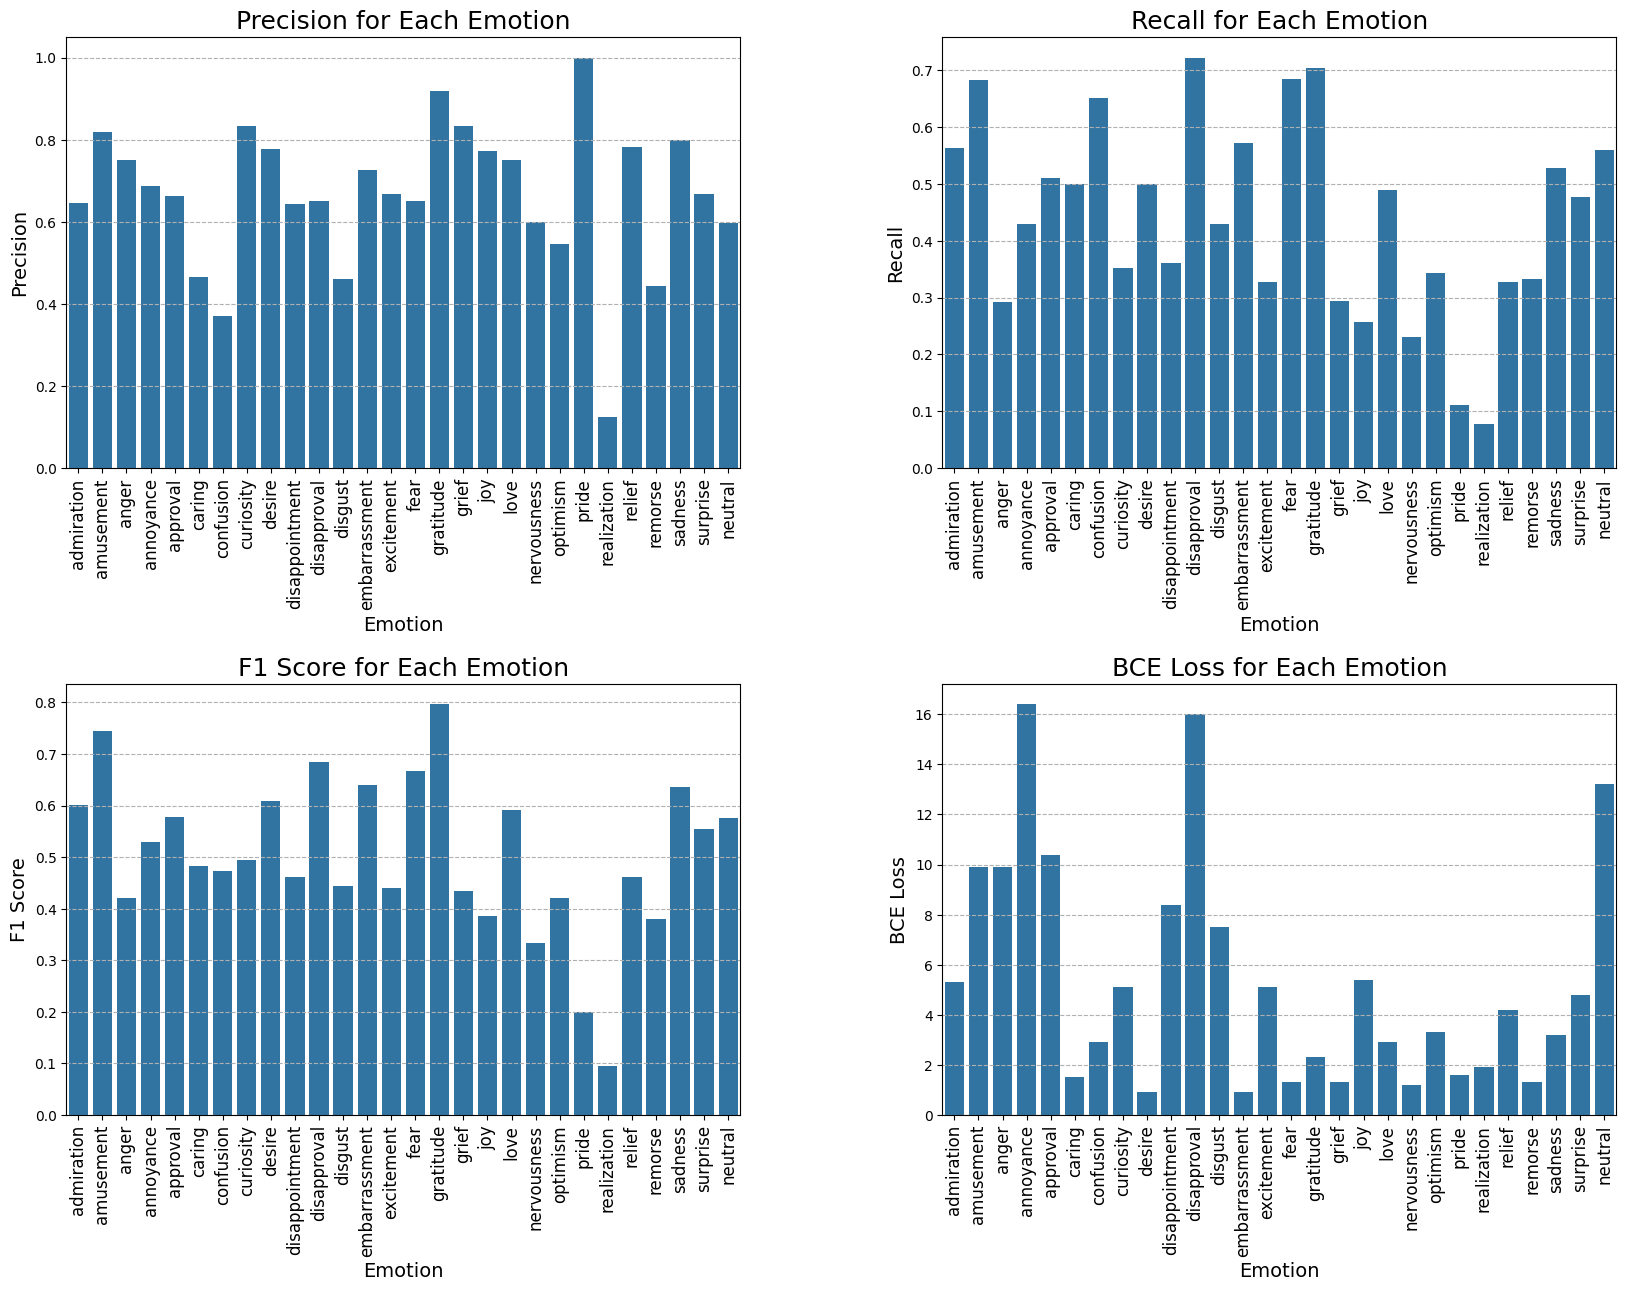

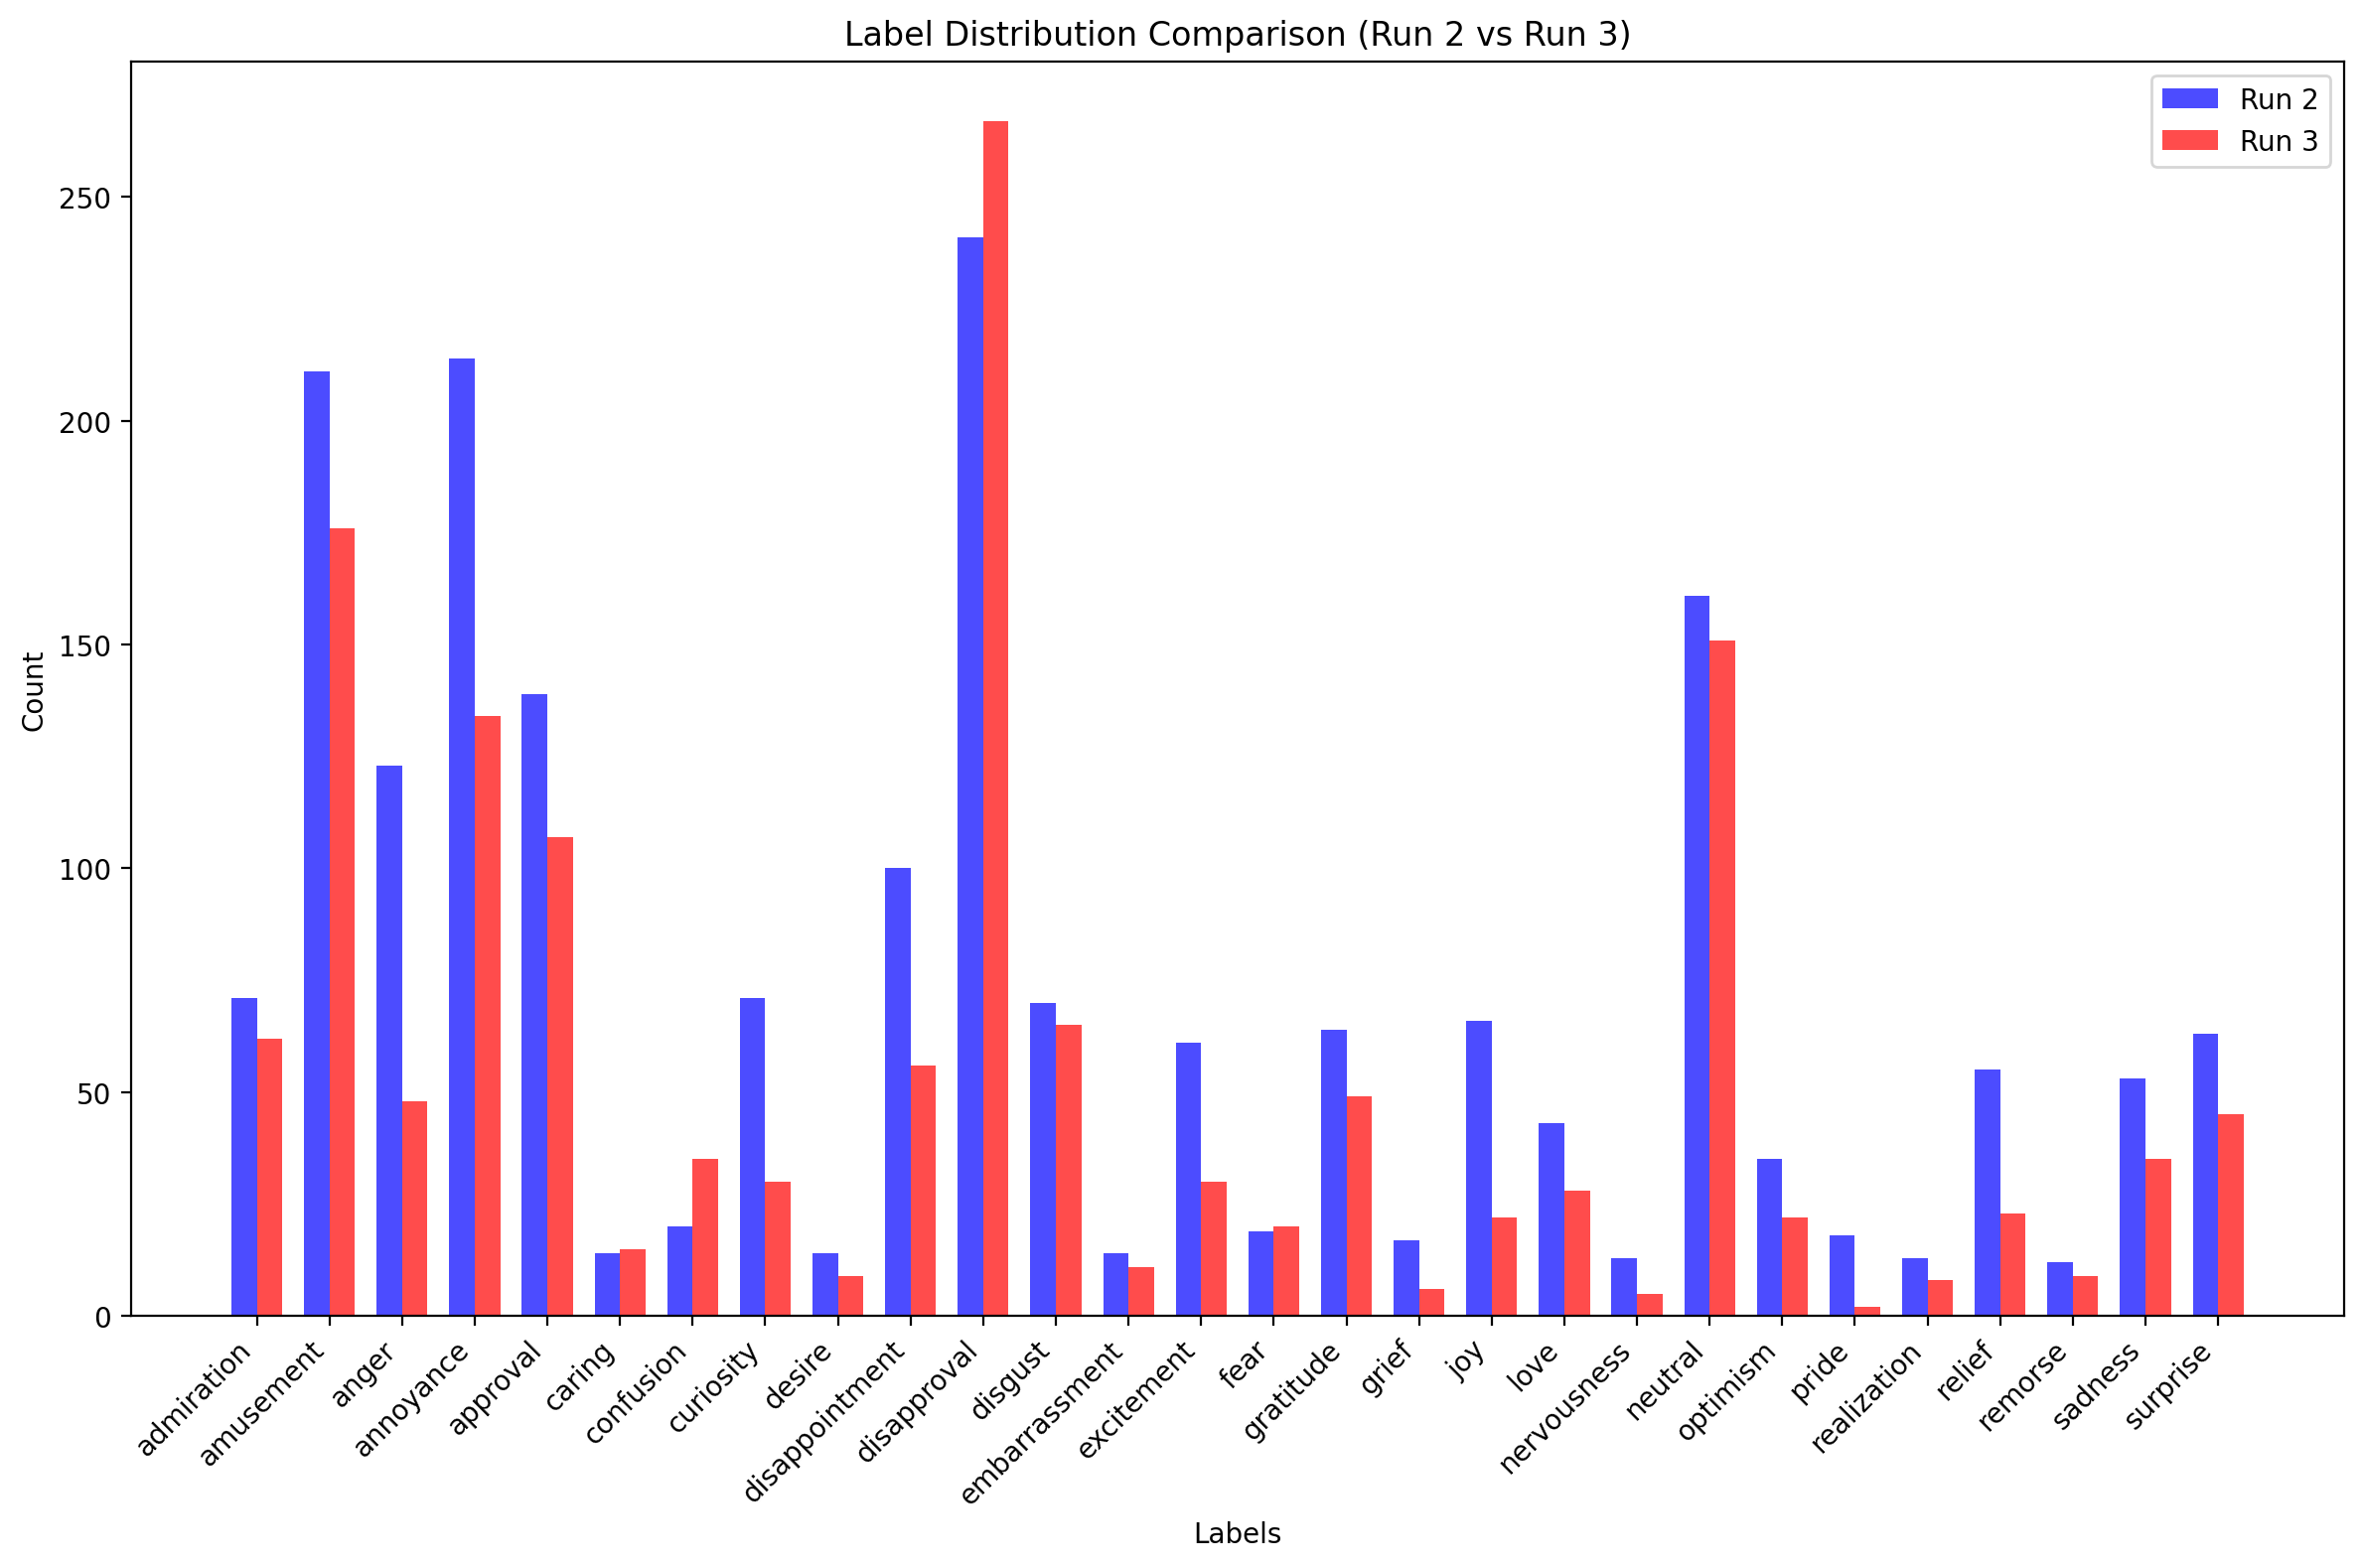

Shannon Entropy - Run 2: 4.2705
Shannon Entropy - Run 3: 4.0699
Gini Coefficient - Run 2: 0.4724
Gini Coefficient - Run 3: 0.5422


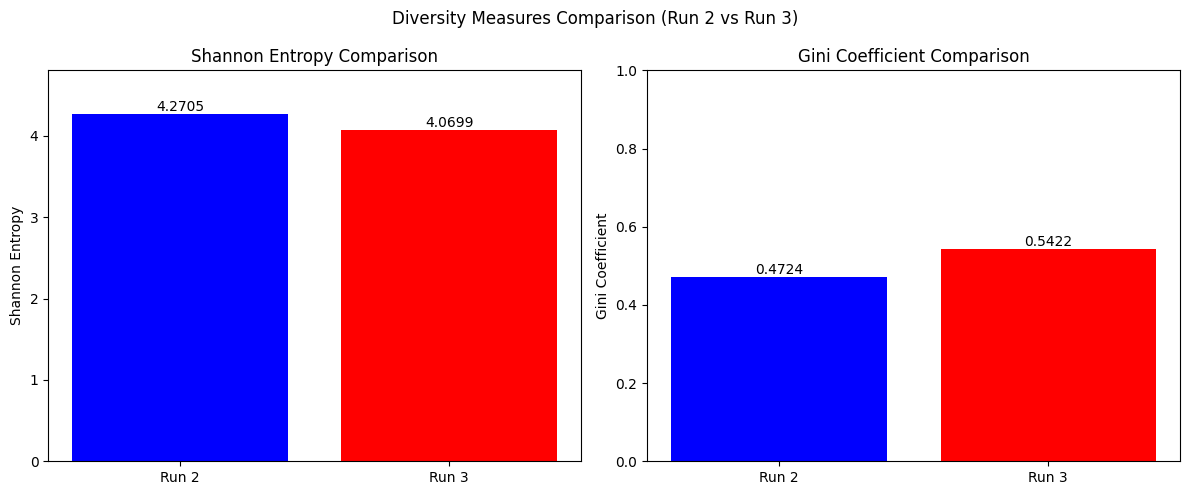

Average number of labels per comment - Run 2: 1.9950
Average number of labels per comment - Run 3: 1.4700


In [3]:
emotion_analysis_comparison_pipeline(
    run_number1=2,
    run_number2=3,
    set_='train',
    EMOTIONS=EMOTIONS,
    plot_percentage = False,
    save=True
)